## Imports


In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
from dotenv import load_dotenv
from os import getenv
from pathlib import Path
from tests import test_mysql_conx, test_pyspark_con

import findspark

findspark.init()

load_dotenv()

False

In [2]:
# MYSQL_CONNECTOR_PATH = "usr/share/java/mysql-connector-java-8.2.0.jar"
MYSQL_CONNECTOR_FILENAME = "mysql-connector-j-8.2.0.jar"
MYSQL_CONNECTOR_PATH = f"./app/mysql_connector/{MYSQL_CONNECTOR_FILENAME}"
Path(MYSQL_CONNECTOR_PATH).exists()

True

Move the connector driver in the proper place in order to be recognizable by pyspark


In [3]:
findspark.add_jars(MYSQL_CONNECTOR_PATH)

In [4]:
CWD: Path = Path("./app/")
EXAMPLE_INPUT_PATH: Path = CWD / Path("./coding_challenge_files/example_input.txt")
TABLE_NAME = "instruments"

Defining mysql credentials


In [5]:
# database connection info
DB_CON_DICT = dict(
    user=getenv("MYSQL_ROOT_USER"),
    password=getenv("MYSQL_ROOT_PASSWORD"),
    host=getenv("HOST"),
    port=int(getenv("MYSQL_DOCKER_PORT")),
    database=getenv("MYSQL_DATABASE"),
)

# Configure MySQL connection properties
MYSQL_PROPERTIES = {
    "driver": "com.mysql.cj.jdbc.Driver",
    "url": "jdbc:mysql://{host}:{port}/{database}".format(**DB_CON_DICT),
    "user": DB_CON_DICT["user"],
    "password": DB_CON_DICT["password"],
}
MYSQL_PROPERTIES

{'driver': 'com.mysql.cj.jdbc.Driver',
 'url': 'jdbc:mysql://db:3306/mydb',
 'user': 'root',
 'password': 'example'}

## Testing Database connection


First we test the connection to our mysql database


In [17]:
# test database connection
test_mysql_conx(**DB_CON_DICT)

Connection Success


## Testing Pyspark installation


Then we test if pyspark is properly installed


In [6]:
test_pyspark_con()

24/01/10 16:40:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+-----+
|value|
+-----+
|Hello|
|World|
+-----+



## TASK PART ONE


Read time series from the file provided and pass all of them to the "calculation module".

Calculation engine needs to calculate:

1. For INSTRUMENT1 – mean

1. For INSTRUMENT2 – mean for November 2014

1. For INSTRUMENT3 – any other statistical calculation that we can compute "on-the-fly" as we read the file (it's up to you)

1. For any other instrument from the input file - sum of the newest 10 elements (in terms of the date).


### `Read time series from the file provided and pass all of them to the "calculation module".`


First we read and transform the data to a pyspark dataframe


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Create a Spark session
spark = (
    SparkSession.builder.appName("Calc_Engine")
    .config("spark.jars", MYSQL_CONNECTOR_PATH)
    .getOrCreate()
)

# Specify the path to the .txt file
txt_file_path: str = f"{EXAMPLE_INPUT_PATH}"

# Define the schema with StringType for DATE initially
schema = StructType(
    [
        StructField(name="INSTRUMENT_NAME", dataType=StringType(), nullable=True),
        StructField(name="DATE", dataType=StringType(), nullable=True),
        StructField(name="VALUE", dataType=DoubleType(), nullable=True),
    ]
)

# Read the .txt file into a PySpark DataFrame
extr = spark.read.option("delimiter", ",").csv(
    txt_file_path, header=False, schema=schema
)

# transform to dataframe
df = extr.toDF("INSTRUMENT_NAME", "DATE", "VALUE")

df.printSchema()

df.show(5)

root
 |-- INSTRUMENT_NAME: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- VALUE: double (nullable = true)

+---------------+-----------+------+
|INSTRUMENT_NAME|       DATE| VALUE|
+---------------+-----------+------+
|    INSTRUMENT1|01-Jan-1996|2.4655|
|    INSTRUMENT1|02-Jan-1996|2.4685|
|    INSTRUMENT1|03-Jan-1996| 2.473|
|    INSTRUMENT1|04-Jan-1996|2.4845|
|    INSTRUMENT1|05-Jan-1996|2.4868|
+---------------+-----------+------+
only showing top 5 rows



Then we properly handle the date column as a date datatype


In [8]:
# Convert the DATE column to a DateType using to_date function and an appropriate date format
from pyspark.sql.functions import to_date

date_format_str = "dd-MMM-yyyy"

# Convert the string to a DateType using to_date function
col_date_str = "DATE"
col_transformed_to_date = "DATE"  # "transformed_date"
col_formatted_Date = "DATE"  # "formatted_date"

df = df.withColumn(col_transformed_to_date, to_date(df[col_date_str], date_format_str))

df.printSchema()

df.show(5)

root
 |-- INSTRUMENT_NAME: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- VALUE: double (nullable = true)

+---------------+----------+------+
|INSTRUMENT_NAME|      DATE| VALUE|
+---------------+----------+------+
|    INSTRUMENT1|1996-01-01|2.4655|
|    INSTRUMENT1|1996-01-02|2.4685|
|    INSTRUMENT1|1996-01-03| 2.473|
|    INSTRUMENT1|1996-01-04|2.4845|
|    INSTRUMENT1|1996-01-05|2.4868|
+---------------+----------+------+
only showing top 5 rows



We sort the Data by Date


In [9]:
from pyspark.sql.functions import col

df = df.orderBy(col("DATE").desc())

df.show(10)

+---------------+----------+-----------+
|INSTRUMENT_NAME|      DATE|      VALUE|
+---------------+----------+-----------+
|    INSTRUMENT1|2014-12-19|   3.475244|
|    INSTRUMENT2|2014-12-19|9.226391955|
|    INSTRUMENT3|2014-12-19|     119.37|
|    INSTRUMENT1|2014-12-18|   3.460937|
|    INSTRUMENT2|2014-12-18|9.223690651|
|    INSTRUMENT3|2014-12-18|    119.275|
|    INSTRUMENT1|2014-12-17|   3.404217|
|    INSTRUMENT2|2014-12-17|9.222419168|
|    INSTRUMENT3|2014-12-17|   117.2525|
|    INSTRUMENT1|2014-12-16|   3.371051|
+---------------+----------+-----------+
only showing top 10 rows



#### `Validate the date - it should be a business date, i.e. Monday – Friday. Discard entries with non-business date.`

In order to achieve this we will use the DAYOFWEEK or dayofweek which transforms the date into a integer according to the day. I.e Mon-Sun -> 1-7. Then we will filter out only the 1-5 integers which are the bussiness days


In [10]:
from pyspark.sql.functions import dayofweek

df.withColumn("DAY_OF_WEEK", dayofweek("DATE")).show(5)

+---------------+----------+-----------+-----------+
|INSTRUMENT_NAME|      DATE|      VALUE|DAY_OF_WEEK|
+---------------+----------+-----------+-----------+
|    INSTRUMENT1|2014-12-19|   3.475244|          6|
|    INSTRUMENT2|2014-12-19|9.226391955|          6|
|    INSTRUMENT3|2014-12-19|     119.37|          6|
|    INSTRUMENT1|2014-12-18|   3.460937|          5|
|    INSTRUMENT2|2014-12-18|9.223690651|          5|
+---------------+----------+-----------+-----------+
only showing top 5 rows



From the [docs](https://dev.mysql.com/doc/refman/7.0/en/date-and-time-functions.html#function_dayofweek) the business days correspond to the integers 2-6 as Monday-Friday

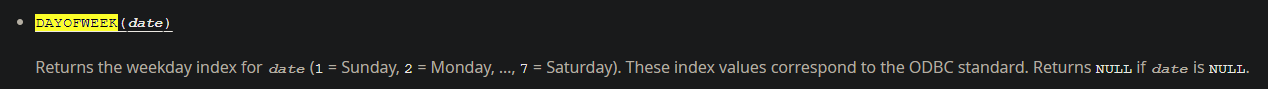


In [11]:
df_with_dayofweek = df.withColumn("DAY_OF_WEEK", dayofweek("DATE"))

# Filter and keep only rows where DAY_OF_WEEK is in [2,6] (Monday=2 to Friday=6)
df_filtered = df_with_dayofweek.filter(
    (df_with_dayofweek["DAY_OF_WEEK"] >= 2) & (df_with_dayofweek["DAY_OF_WEEK"] <= 6)
)

df_filtered.show(5)

+---------------+----------+-----------+-----------+
|INSTRUMENT_NAME|      DATE|      VALUE|DAY_OF_WEEK|
+---------------+----------+-----------+-----------+
|    INSTRUMENT1|2014-12-19|   3.475244|          6|
|    INSTRUMENT2|2014-12-19|9.226391955|          6|
|    INSTRUMENT3|2014-12-19|     119.37|          6|
|    INSTRUMENT1|2014-12-18|   3.460937|          5|
|    INSTRUMENT2|2014-12-18|9.223690651|          5|
+---------------+----------+-----------+-----------+
only showing top 5 rows



Check that the df_filtered contains indeed only bussiness days


In [12]:
from pyspark.sql.functions import max, min

max_value = df_filtered.agg(max("DAY_OF_WEEK").alias("MAX")).collect()[0]["MAX"]
min_value = df_filtered.agg(min("DAY_OF_WEEK").alias("MIN")).collect()[0]["MIN"]

if (min_value, max_value) == (2, 6):
    print("df_filtered contains indeed only bussiness days")

df_filtered contains indeed only bussiness days


The .txt file already contains only business days by the way as can be seen from


In [13]:
max_value = df_with_dayofweek.agg(max("DAY_OF_WEEK").alias("MAX")).collect()[0]["MAX"]
min_value = df_with_dayofweek.agg(min("DAY_OF_WEEK").alias("MIN")).collect()[0]["MIN"]

if (min_value, max_value) == (2, 6) or df_with_dayofweek.count() == df_filtered.count():
    print("df_filtered contains indeed only bussiness days")

df_filtered contains indeed only bussiness days


#### `Current date is 19-Dec-2014 and we cannot have dates past that`


In [ ]:
from datetime import date as dt_date

latest_date = df_filtered.agg(max("DATE").alias("MAX")).collect()[0]["MAX"]
if latest_date == dt_date(2014, 12, 19):
    print("Indeed our dataframe contains dates up to 19-Dec-2014")

Indeed our dataframe contains dates up to 19-Dec-2014


### `For INSTRUMENT1 – mean`


In [82]:
mean_value_INST1 = (
    df_filtered.groupBy("INSTRUMENT_NAME")
    .agg(mean("VALUE").alias("MEAN"))
    .filter(col("INSTRUMENT_NAME") == "INSTRUMENT1")
)

mean_value_INST1.show()

+---------------+-----------------+
|INSTRUMENT_NAME|             MEAN|
+---------------+-----------------+
|    INSTRUMENT1|3.367591731889919|
+---------------+-----------------+



### `For INSTRUMENT2 – mean for November 2014`


We first group by Year, Month and then we calculate the mean


In [17]:
from pyspark.sql.functions import month, year, day

df_grouped_year_month = df_filtered.groupBy(
    "INSTRUMENT_NAME", year("DATE").alias("YEAR"), month("DATE").alias("MONTH")
).agg({"VALUE": "mean"})

# Show the result
df_grouped_year_month.show(5)

+---------------+----+-----+------------------+
|INSTRUMENT_NAME|YEAR|MONTH|        avg(VALUE)|
+---------------+----+-----+------------------+
|    INSTRUMENT2|2008|    1| 9.233828654869566|
|    INSTRUMENT2|2004|   12| 9.304511043695655|
|    INSTRUMENT3|2002|    7| 119.5754347826087|
|    INSTRUMENT1|2012|    1|3.3943136363636373|
|    INSTRUMENT3|2010|    4| 93.57292772727273|
+---------------+----+-----+------------------+
only showing top 5 rows



Then we extract the needed mean for November 2014


In [94]:
# Specify the year, month, and instrument to filter
target_year = 2014
target_month = 11
target_instrument = "INSTRUMENT2"

# Filter the DataFrame
mean_value_INST2_2014_11 = df_grouped_year_month.filter(
    (col("YEAR") == target_year)
    & (col("MONTH") == target_month)
    & (col("INSTRUMENT_NAME") == target_instrument)
)

mean_value_INST2_2014_11.show()

+---------------+----+-----+-------------+
|INSTRUMENT_NAME|YEAR|MONTH|   avg(VALUE)|
+---------------+----+-----+-------------+
|    INSTRUMENT2|2014|   11|9.25755836695|
+---------------+----+-----+-------------+



### `For INSTRUMENT3 – any other statistical calculation that we can compute "on-the-fly" as we read the file (it's up to you)`


Just like in pandas the on-the-fly statistical calculations are generated by .desc() method or .describe() in pyspark


In [109]:
# Filter only the rows where 'INSTRUMENT_NAME' is 'INSTRUMENT3'
instrument3_df = df_filtered.filter(col("INSTRUMENT_NAME") == "INSTRUMENT3")

# Apply describe()
instrument3_stats = instrument3_df.describe()

# keep only meaningful columns
instrument3_stats.select("summary", "VALUE").show()

+-------+------------------+
|summary|             VALUE|
+-------+------------------+
|  count|              4942|
|   mean|109.31133151073693|
| stddev|15.220281324517314|
|    min|           75.7195|
|    max|            149.98|
+-------+------------------+



### `For any other instrument from the input file - sum of the newest 10 elements (in terms of the date).`


Let us first find how many distinct instruments are there in our dataset


In [113]:
df_filtered.select("INSTRUMENT_NAME").distinct().show()

+---------------+
|INSTRUMENT_NAME|
+---------------+
|    INSTRUMENT2|
|    INSTRUMENT1|
|    INSTRUMENT3|
+---------------+



We will first drop the DAY_OF_WEEK column then add YEAR, MONTH and DAY columns

In [18]:
df_ordered_grouped = df_filtered.drop('DAY_OF_WEEK')\
    .withColumn("YEAR", year("DATE"))\
    .withColumn("MONTH", month("DATE"))\
    .withColumn("DAY", day("DATE"))\
    .orderBy(
        col("INSTRUMENT_NAME"),
        col("YEAR").desc(),
        col("MONTH").desc(),
        col("DAY").desc(),
    )
    
df_ordered_grouped.show(5)

+---------------+----------+--------+----+-----+---+
|INSTRUMENT_NAME|      DATE|   VALUE|YEAR|MONTH|DAY|
+---------------+----------+--------+----+-----+---+
|    INSTRUMENT1|2014-12-19|3.475244|2014|   12| 19|
|    INSTRUMENT1|2014-12-18|3.460937|2014|   12| 18|
|    INSTRUMENT1|2014-12-17|3.404217|2014|   12| 17|
|    INSTRUMENT1|2014-12-16|3.371051|2014|   12| 16|
|    INSTRUMENT1|2014-12-15|3.361023|2014|   12| 15|
+---------------+----------+--------+----+-----+---+
only showing top 5 rows



In [31]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, sum

# Define a window specification partitioned by 'INSTRUMENT_NAME' and ordered by date columns
# just like df_ordered_grouped
window_spec = Window.partitionBy("INSTRUMENT_NAME").orderBy(
    col("YEAR").desc(),
    col("MONTH").desc(),
    col("DAY").desc(),
)

# Add a row number column to the DataFrame based on the window specification
df_with_row_number = df_ordered_grouped.withColumn("row_num", row_number().over(window_spec))

Let us first inspect what this looks like and if it is correct

In [28]:
df_with_row_number.filter(col('INSTRUMENT_NAME')=='INSTRUMENT1').show(11)

+---------------+----------+--------+----+-----+---+-------+
|INSTRUMENT_NAME|      DATE|   VALUE|YEAR|MONTH|DAY|row_num|
+---------------+----------+--------+----+-----+---+-------+
|    INSTRUMENT1|2014-12-19|3.475244|2014|   12| 19|      1|
|    INSTRUMENT1|2014-12-18|3.460937|2014|   12| 18|      2|
|    INSTRUMENT1|2014-12-17|3.404217|2014|   12| 17|      3|
|    INSTRUMENT1|2014-12-16|3.371051|2014|   12| 16|      4|
|    INSTRUMENT1|2014-12-15|3.361023|2014|   12| 15|      5|
|    INSTRUMENT1|2014-12-12|3.356631|2014|   12| 12|      6|
|    INSTRUMENT1|2014-12-11|3.370752|2014|   12| 11|      7|
|    INSTRUMENT1|2014-12-10|3.353995|2014|   12| 10|      8|
|    INSTRUMENT1|2014-12-09|3.346407|2014|   12|  9|      9|
|    INSTRUMENT1|2014-12-08|3.387239|2014|   12|  8|     10|
|    INSTRUMENT1|2014-12-05|3.388378|2014|   12|  5|     11|
+---------------+----------+--------+----+-----+---+-------+
only showing top 11 rows



In [29]:
df_with_row_number.filter(col('INSTRUMENT_NAME')=='INSTRUMENT2').show(11)

+---------------+----------+-----------+----+-----+---+-------+
|INSTRUMENT_NAME|      DATE|      VALUE|YEAR|MONTH|DAY|row_num|
+---------------+----------+-----------+----+-----+---+-------+
|    INSTRUMENT2|2014-12-19|9.226391955|2014|   12| 19|      1|
|    INSTRUMENT2|2014-12-18|9.223690651|2014|   12| 18|      2|
|    INSTRUMENT2|2014-12-17|9.222419168|2014|   12| 17|      3|
|    INSTRUMENT2|2014-12-16|9.216989169|2014|   12| 16|      4|
|    INSTRUMENT2|2014-12-15|9.216693028|2014|   12| 15|      5|
|    INSTRUMENT2|2014-12-12|9.214624074|2014|   12| 12|      6|
|    INSTRUMENT2|2014-12-11|9.208970562|2014|   12| 11|      7|
|    INSTRUMENT2|2014-12-10| 9.20228434|2014|   12| 10|      8|
|    INSTRUMENT2|2014-12-09|9.299184555|2014|   12|  9|      9|
|    INSTRUMENT2|2014-12-08|9.203948953|2014|   12|  8|     10|
|    INSTRUMENT2|2014-12-05|9.299832024|2014|   12|  5|     11|
+---------------+----------+-----------+----+-----+---+-------+
only showing top 11 rows



In [30]:
df_with_row_number.filter(col('INSTRUMENT_NAME')=='INSTRUMENT3').show(11)

+---------------+----------+--------+----+-----+---+-------+
|INSTRUMENT_NAME|      DATE|   VALUE|YEAR|MONTH|DAY|row_num|
+---------------+----------+--------+----+-----+---+-------+
|    INSTRUMENT3|2014-12-19|  119.37|2014|   12| 19|      1|
|    INSTRUMENT3|2014-12-18| 119.275|2014|   12| 18|      2|
|    INSTRUMENT3|2014-12-17|117.2525|2014|   12| 17|      3|
|    INSTRUMENT3|2014-12-16| 116.785|2014|   12| 16|      4|
|    INSTRUMENT3|2014-12-15| 118.275|2014|   12| 15|      5|
|    INSTRUMENT3|2014-12-12|118.8075|2014|   12| 12|      6|
|    INSTRUMENT3|2014-12-11| 119.225|2014|   12| 11|      7|
|    INSTRUMENT3|2014-12-10|118.5975|2014|   12| 10|      8|
|    INSTRUMENT3|2014-12-09|118.3175|2014|   12|  9|      9|
|    INSTRUMENT3|2014-12-08|129.8475|2014|   12|  8|     10|
|    INSTRUMENT3|2014-12-05|129.6075|2014|   12|  5|     11|
+---------------+----------+--------+----+-----+---+-------+
only showing top 11 rows



Hence we can see that the row numbers have been properly added denoting the last 10 entries for each instrument according to the dates.

Next we filter only the row numbers up to 10

In [32]:
# Filter rows where row number is less than or equal to 10
df_last_10 = df_with_row_number.filter(col("row_num") <= 10)

Let us check the dataframe

In [36]:
df_last_10.show(30)

+---------------+----------+-----------+----+-----+---+-------+
|INSTRUMENT_NAME|      DATE|      VALUE|YEAR|MONTH|DAY|row_num|
+---------------+----------+-----------+----+-----+---+-------+
|    INSTRUMENT1|2014-12-19|   3.475244|2014|   12| 19|      1|
|    INSTRUMENT1|2014-12-18|   3.460937|2014|   12| 18|      2|
|    INSTRUMENT1|2014-12-17|   3.404217|2014|   12| 17|      3|
|    INSTRUMENT1|2014-12-16|   3.371051|2014|   12| 16|      4|
|    INSTRUMENT1|2014-12-15|   3.361023|2014|   12| 15|      5|
|    INSTRUMENT1|2014-12-12|   3.356631|2014|   12| 12|      6|
|    INSTRUMENT1|2014-12-11|   3.370752|2014|   12| 11|      7|
|    INSTRUMENT1|2014-12-10|   3.353995|2014|   12| 10|      8|
|    INSTRUMENT1|2014-12-09|   3.346407|2014|   12|  9|      9|
|    INSTRUMENT1|2014-12-08|   3.387239|2014|   12|  8|     10|
|    INSTRUMENT2|2014-12-19|9.226391955|2014|   12| 19|      1|
|    INSTRUMENT2|2014-12-18|9.223690651|2014|   12| 18|      2|
|    INSTRUMENT2|2014-12-17|9.222419168|

Finally we group by the INSTRUMENT_NAME column and sum the VALUE column

In [34]:
# Group by 'INSTRUMENT_NAME' and calculate the sum of 'VALUE'
sum_values = df_last_10.groupBy("INSTRUMENT_NAME").agg(sum("VALUE").alias("SUM_VALUE_LAST_10"))

# Show the result
sum_values.show()

+---------------+-----------------+
|INSTRUMENT_NAME|SUM_VALUE_LAST_10|
+---------------+-----------------+
|    INSTRUMENT1|        33.887496|
|    INSTRUMENT2|92.23519645500001|
|    INSTRUMENT3|        1195.7525|
+---------------+-----------------+

